<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />



This notebook is prepared as part of the GEOS 636 class project by [Amrit Thapa](https://amrit-thapa-2044.github.io/). It aims to showcase the process of comparing displacements obtained from InSAR with GPS observations. The notebook utilizes functions from the MintPy Python package to download GPS data and conduct a comparison with InSAR Line-of-Sight (LOS) displacement.

For this project, I employed pre-processed InSAR time series data. However, individuals interested in working with InSAR time series can utilize MintPy for the same purpose.

In [ ]:
# install mintpy package, colab does not come with mintpy installed
!pip install mintpy
!pip install plotnine

In [ ]:
# load all requied packages
import os
import os, copy
import shutil
import subprocess
from osgeo import gdal, ogr
import numpy as np
import pandas as pd
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, utils as ut
from mintpy.objects import gps, timeseries
from datetime import datetime as dt
from plotnine import *
from matplotlib import colors


In [ ]:
# path to InSAR data
mintpy_dir='/content/drive/MyDrive/Colab Notebooks/class_project_geos_636'
os.chdir(mintpy_dir)

insar_ts_file='timeseries.h5' # insar result from insar time series analysis
maskTempCoh='maskTempCoh.h5'

# details of reference location, the insar result with be referenced to this GPS location
ref_site = 'KIRT' # if you don't know this code you can use nearest_UNAVC_GPS in the other notebook to find this
ref_lat= 27.682
ref_lon= 85.288

# station for comparison , this is the station where insar will be compared, validated make sure that the data quality is good enough
sites_for_comparison='NAST' # again you can use other notebook to see station details/ make plots

In [ ]:
# grab the time-series file used for time function estimation given the template setup
# read the time-series file
insar_ts, atr = readfile.read(insar_ts_file, datasetName='timeseries')
mask = readfile.read(os.path.join(mintpy_dir, maskTempCoh))[0]
print(f'reading timeseries from file: {insar_ts_file}')

# Get date list
date_list = timeseries(insar_ts_file).get_date_list()
num_date = len(date_list)
date0, date1 = date_list[0], date_list[-1]
insar_dates = ptime.date_list2vector(date_list)[0]

# spatial reference
coord = ut.coordinate(atr)
ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
print('y,x',ref_y, ref_x)
if not mask[ref_y, ref_x]:
    raise ValueError(f'Given reference GNSS site ({ref_site}) is in mask-out unrelible region in InSAR! Change to a different site.')
ref_insar_dis = insar_ts[:, ref_y, ref_x]

reading timeseries from file: timeseries.h5
y,x 83 14


In [ ]:
# Retrieve GPS data from the specific location where validation/comparison with InSAR is required.
gnss_obj = gps.GPS(site=sites_for_comparison, data_dir=mintpy_dir+'/GPS')
gnss_dates, gnss_dis, _, gnss_lalo = gnss_obj.read_gps_los_displacement(atr, start_date=date0, end_date=date1, ref_site=ref_site)[:4]

# shift GNSS to zero-mean in time [for plotting purpose]
gnss_dis -= np.nanmedian(gnss_dis)

# read InSAR
y, x = coord.geo2radar(gnss_lalo[0], gnss_lalo[1])[:2]
insar_dis = insar_ts[:, y, x] - ref_insar_dis
# apply a constant shift in time to fit InSAR to GNSS
comm_dates = sorted(list(set(gnss_dates) & set(insar_dates)))
if comm_dates:
    insar_flag = [x in comm_dates for x in insar_dates]
    gnss_flag = [x in comm_dates for x in gnss_dates]
    insar_dis -= np.nanmedian(insar_dis[insar_flag] - gnss_dis[gnss_flag])

In [ ]:
# Store GPS and InSAR data as dataframes; although it might require a few more lines, I prefer working with pandas for its ease of use.
df_GPS_i = pd.DataFrame({})
df_GPS_i['dis_GPS']=pd.Series(gnss_dis*100, dtype=float)
df_GPS_i['Date']=gnss_dates

df_insar_i = pd.DataFrame({})
df_insar_i['dis_InSAR']=pd.Series(insar_dis*100, dtype=float)
df_insar_i['Date']=insar_dates

In [ ]:
# Merge two DataFrames, df_insar_i and df_GPS_i, on the 'Date' column using an outer join.
# This means that all dates present in either DataFrame will be included in the merged DataFrame.
# The result is stored in df_both, dates having no data are filled with nans.
df_both=pd.merge(df_insar_i, df_GPS_i, on='Date', how='outer').fillna(np.nan)
df_both.head()

,dis_InSAR,Date,dis_GPS
0,3.243045,2018-01-23,NaN
1,2.966677,2018-02-04,NaN
2,2.904066,2018-02-16,2.622271
3,2.381858,2018-02-28,2.904224
4,2.569077,2018-03-12,1.829505


In [ ]:
 # calculate correlation between GPS and InSAR, corr function takes care of nans
 cc=df_both['dis_InSAR'].corr(df_both['dis_GPS'])
 print(f"Correlation is: {cc:.2f}")

# from sklearn.metrics import mean_squared_error; this was throwing error as the data has nan
# i wrote rmse formulae and it works
rmse=np.sqrt(np.mean((df_both['dis_InSAR']-df_both['dis_GPS'])**2))
print(f"Root Mean Squared Error is: {rmse:.2f}")

Correlation is: 0.93
Root Mean Squared Error is: 0.82



With a background in R programming, I've extensively used ggplot for creating visually appealing plots. Fortunately, I found the plotnine package [https://jeroenjanssens.com/plotnine/], which is the Python equivalent of ggplot. Now, let's create some visually appealing plots using plotnine.

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 285 rows containing missing values.


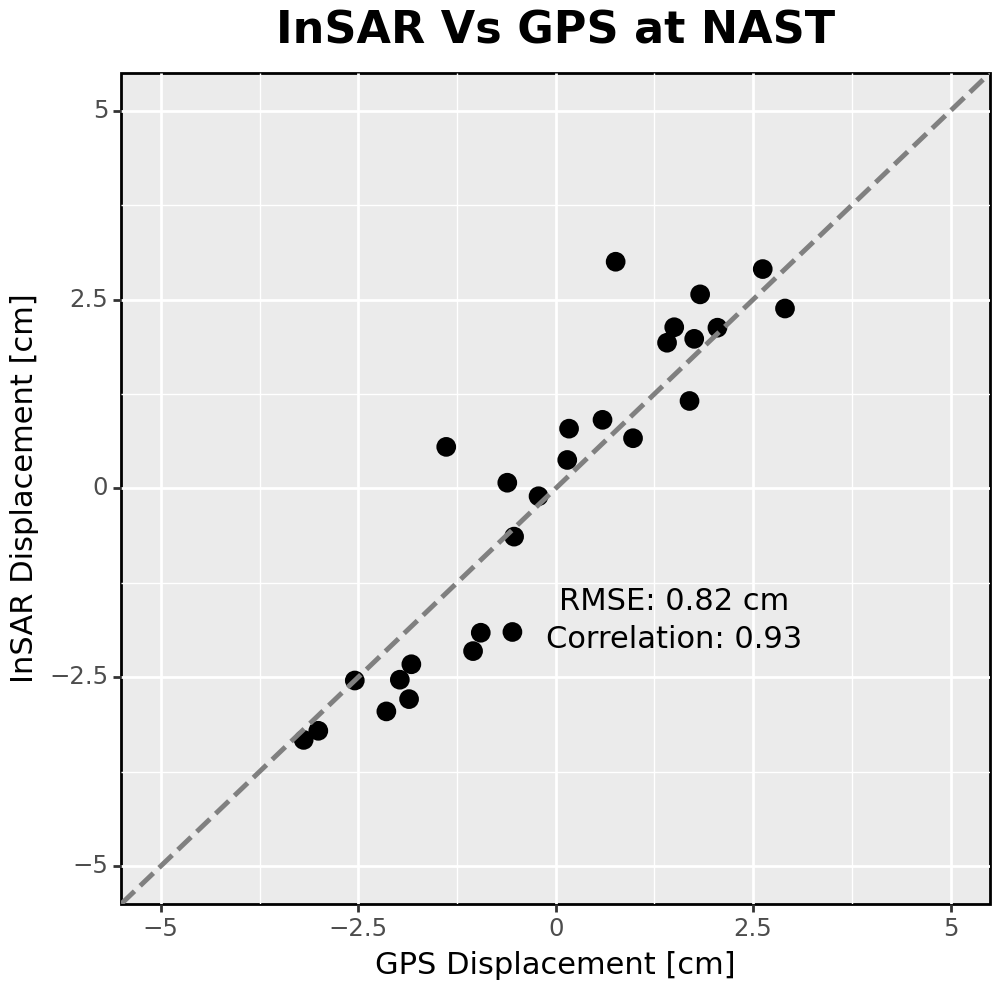

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: NASTVs_InSAR.png
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 285 rows containing missing values.


In [ ]:
# make scatter plot
p_scatter=ggplot(df_both, aes(x='dis_GPS', y='dis_InSAR')) + \
geom_point(size=3) + \
  labs(title='InSAR Vs GPS at '+sites_for_comparison,y='InSAR Displacement [cm]',x='GPS Displacement [cm]')+ \
  theme(plot_title = element_text(hjust = 0.5,size = 16, face = "bold"))+\
    theme(legend_position='none')+ylim(-5,5)+xlim(-5,5)+\
    geom_abline(slope=1, intercept=0, linetype='dashed', color='grey',size=1)+\
    annotate('text', x=1.5, y =-2,label=f"Correlation: {cc:.2f}")+\
    annotate('text', x=1.5, y =-1.5,label=f"RMSE: {rmse:.2f} cm")+\
    theme(panel_border = element_rect(colour = "black"))+\
    theme(figure_size=(5, 5))

print(p_scatter)
p_scatter.save(f'{sites_for_comparison}Vs_InSAR.png', width=10, height=10, dpi=300)

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 285 rows containing missing values.


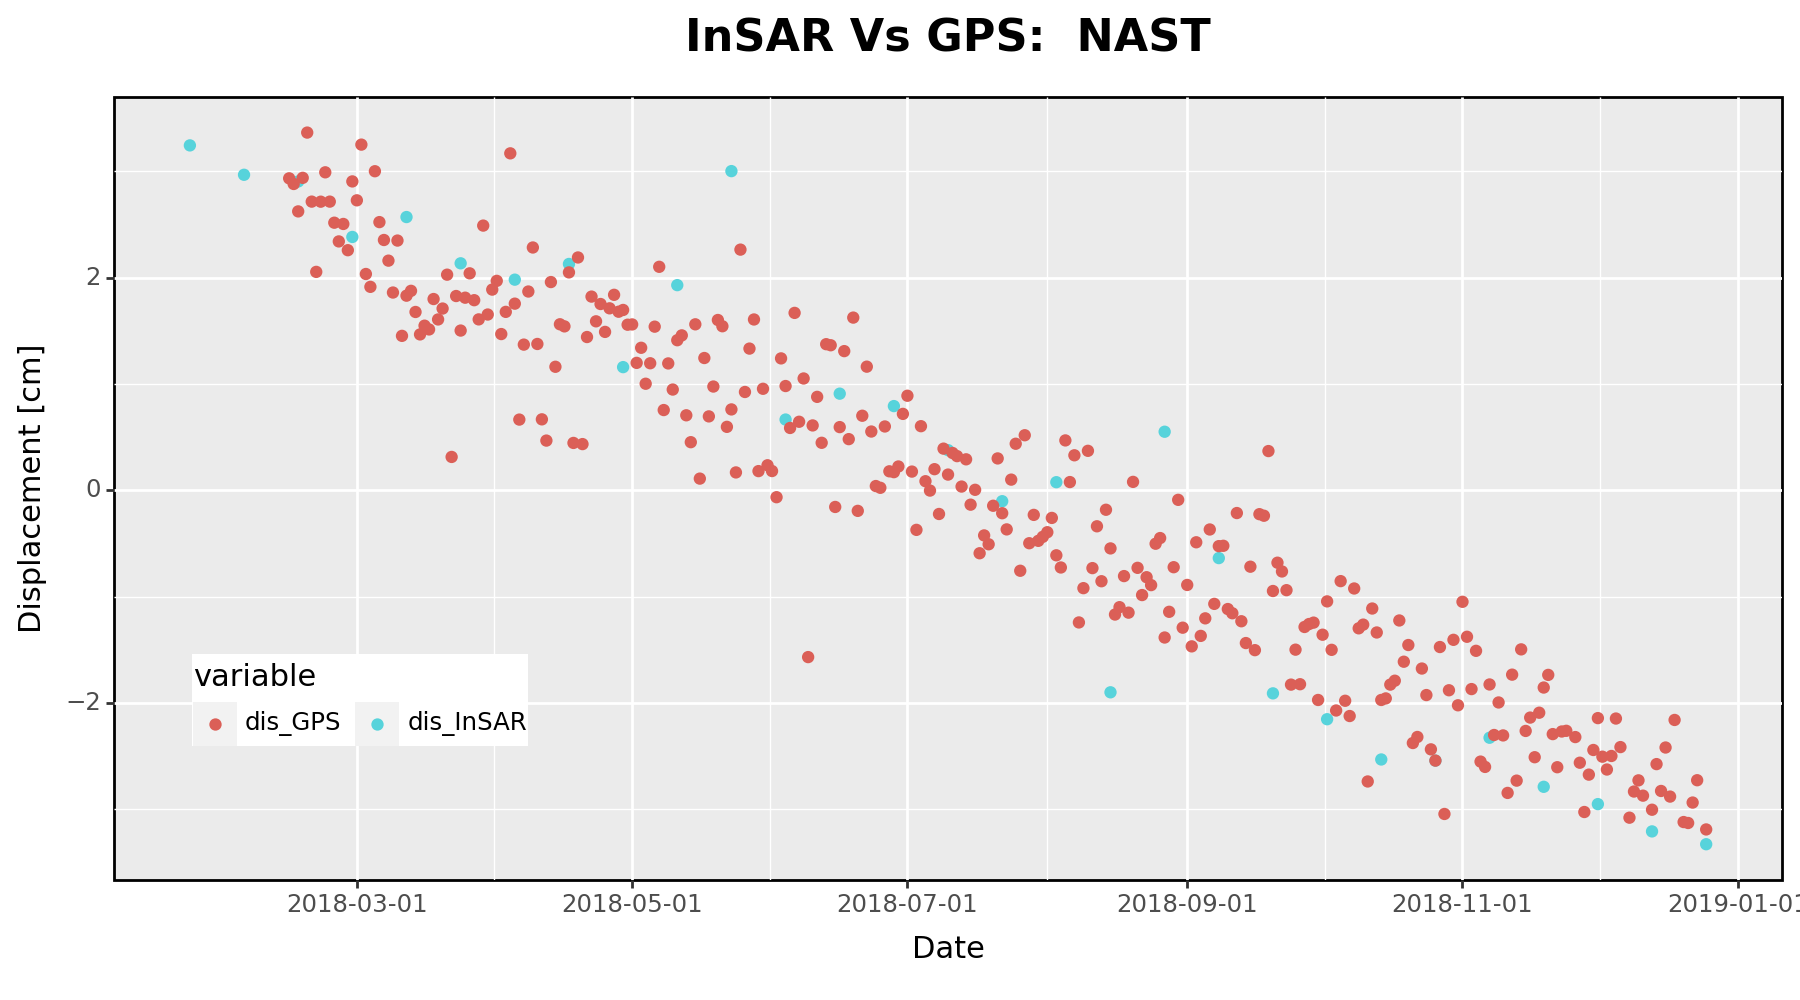

<Figure Size: (900 x 500)>

In [ ]:
# make line plot
# melt on Date
df_melted = df_both.melt("Date")

ggplot(df_melted, aes(x='Date', y='value',color='variable',group='variable')) + \
geom_point() + \
  labs(title='InSAR Vs GPS:  '+sites_for_comparison,y='Displacement [cm]',x='Date')+\
    theme(plot_title = element_text(hjust = 0.5,size = 16, face = "bold"))+\
  theme(figure_size=(9, 5))+\
  theme(legend_position=(0.2,0.3))+\
  theme(panel_border = element_rect(colour = "black"))